In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

In [2]:
from unnet.samplers import *
from unnet.pipeline import *
from unnet.generators import *
from unnet.visualize import *
from unnet.centralities import *
from unnet.RealDataSets import *
from unnet.GEXFConverter import *


In [3]:
class RealDatasetLoader(ParamsSetter):
    def __init__(self):
        self.name = None
        self.use_cache=True
        self.cache = {}
        self.use_connected_component = True
    
    @property
    def parameters_mapping(self):
        return {'name' : 'name',}
    
    def execute(self,):
        if self.use_cache==True:
            if self.name in self.cache:
                return self.cache[self.name]
        G = self.load()
        if self.use_cache:
            self.cache[self.name] = G
        return G
    def load(self):
        
        if self.name=='brazil':
            G = load_brazil_dataset()
        
        if self.name=='pok':
            G =  load_pok_dataset()
        
        if self.name=='aps':
            G =  load_aps_dataset()
        
        if self.name=='github':
            G =  load_github_dataset()
        
        if self.name=='dblp':
            G =  load_dblp_dataset()
        if self.use_connected_component:
            import graph_tool as gt
            import graph_tool.topology as topo
            labels = topo.label_largest_component(G)
            G = gt.remove_parallel_edges(gt.Graph(gt.GraphView(G, vfilt = labels), prune=True))
        return G
    
graphs = ParametersZip(RealDatasetLoader(), {'name': ['github', 'pok', 'brazil', 'aps', 'dblp']})

m = 1
n = 10000

measures=JoinMeasures([
    DegreeByClass(["top_places", "distr_cumsum", "distr"], minlength=m*n),
    #PagerankByClass(["top_places", "distr_cumsum"], minlength=m*n),
    #KatzByClass(["top_places", "distr_cumsum"], minlength=m*n),
    MinorityFraction(),
#    BetweennessByClass(["top_places", "distr_cumsum"], minlength=m*n)
])


In [17]:
from unnet.utils import attribute_ac
def assortativity_inner(arr):
    tmp=np.zeros(4)
    tmp[:len(arr)]=arr[:]
    arr=tmp.reshape((2,2))
    arr[0,1] = (arr[0,1] + arr[1,0])
    arr[1,0] = arr[0,1]



    print(arr)
    return attribute_ac(arr)
    #arr[0,0]=2 * arr[0,0]
    #arr[1,1]=2 * arr[1,1]
    #arr/=np.sum(arr)
    #print(arr)
    #e_mm=float(arr[1,1]+arr[0,1]+arr[1,0])
    #e_MM=float(arr[0,0]+arr[0,1]+arr[1,0])
    #a=np.sum(arr, axis=0)[:]
    #b=np.sum(arr, axis=1)[:]
    #E=np.sum(arr[:])
    #return  (arr[0,0]  + arr[1,1] - np.sum(a*b))/(1 - np.sum(a*b))

In [18]:
#show Dataset statistics
if True:
    #from unnet.utils import assortativity_inner
    
    loader = RealDatasetLoader()
    
    import graph_tool.all as gt
    names=['github', 'pok', 'brazil', 'aps', 'dblp']
    tuples = []
    for name in names:

        loader.name=name
        G=loader.execute()
        print()
        tmp = (name,
               G.num_vertices(),-1
               G.num_edges(),
               gt.modularity(G, G.vp.minority),
               assortativity_inner(EdgeCountByClass('raw').get_values(G)),
               np.sum(G.vp.minority.get_array())/G.num_vertices())
        tuples.append(tmp)
    print(pd.DataFrame.from_records(tuples,
                                    columns=["name", "nodes", "edges", "modularity", 'assortativity', "minority"]).to_latex())

<Graph object, undirected, with 151325 vertices and 268461 edges, 1 internal vertex property, at 0x7f887b2221f0>

[[   990.  19387.]
 [ 19387. 228073.]]

[[ 2679. 21268.]
 [21268.  1162.]]

[[    0. 38540.]
 [38540.     0.]]

[[ 768.  170.]
 [ 170. 2126.]]

[[ 32345. 179283.]
 [179283. 407629.]]
\begin{tabular}{llrrrrl}
\toprule
{} &    name &   nodes &   edges &  modularity &  assortativity &             minority \\
\midrule
0 &  github &  119875 &  248450 &    0.004271 &      -0.029760 &  0.04769134515119917 \\
1 &     pok &   25110 &   25109 &   -0.348852 &      -0.836322 &  0.42994822779769015 \\
2 &  brazil &   15810 &   38540 &   -0.500000 &      -1.000000 &   0.3895003162555345 \\
3 &     aps &    1281 &    3064 &    0.346299 &       0.744722 &  0.31772053083528495 \\
4 &    dblp &  185607 &  619257 &    0.026855 &      -0.152629 &   0.2132839817463781 \\
\bottomrule
\end{tabular}



\begin{tabular}{llrrrl}
\toprule
{} &    name &   nodes &   edges &  modularity &             minority \\
\midrule
0 &  github &  119875 &  248450 &    0.004271 &  0.04769134515119917 \\
1 &     pok &   25110 &   25109 &   -0.348852 &  0.42994822779769015 \\
2 &  brazil &   15810 &   38540 &   -0.500000 &   0.3895003162555345 \\
3 &     aps &    1281 &    3064 &    0.346299 &  0.31772053083528495 \\
4 &    dblp &  185607 &  619257 &    0.026855 &   0.2132839817463781 \\
\bottomrule
\end{tabular}



In [88]:
if False:
    show_std=True
    mode="unsafe"
    result1=GraphPipeline(graphs, measures).execute(repetitions=1)
    for measure in ["degree"]:#, "pagerank", "katz", "betweenness"]:
        figs_degree = plot_distr_cumsum(result1, measure=measure,show_std=show_std, mode=mode)
        display(Markdown(f"# cumsum for {measure}"))
        for fig in figs_degree:
            display(fig)

In [89]:
loader = RealDatasetLoader()
loader.name="pok"
G=loader.execute()

In [90]:
G2=G.copy()
#num_v = G2.num_vertices()
#arr=np.vstack([np.arange(num_v), np.arange(num_v)])
arr=np.vstack([G2.get_vertices(),G2.get_vertices()]).T
G2.add_edge_list(arr)

In [91]:
print(G2.num_edges())
graph = G2
edges = graph.get_edges()
edges = edges[np.logical_not(edges[:,0]==edges[:,1])]
similarities = topology.vertex_similarity(graph,  vertex_pairs=edges)


50219


In [92]:
edges[:,0]==edges[:,1]

array([False, False, False, ..., False, False, False])

0.4

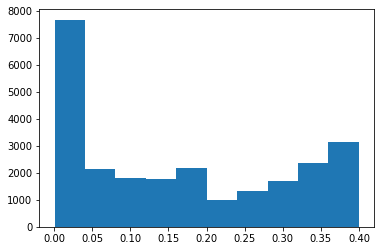

In [93]:
plt.hist(similarities)
np.max(similarities)

In [94]:

similarities1 = topology.vertex_similarity(G,  vertex_pairs=G.get_edges())
np.sum(similarities1)

0.0

In [95]:
def my_cmap(x):
    return plt.get_cmap("Reds")(x/2)
def plot(result, measure="degree", cmap=None, **kwargs):
    plt.set_cmap("Reds")
    for name in np.unique(result.name):
        display(Markdown(f"# {name}"))
        result_tmp = result[result.name ==name]
        for measure in ["degree"]:#, "pagerank", "katz"]:#, "katz", "betweenness"]:
            display(Markdown(f"### {measure}"))
            fig = plot_top_places(result_tmp, measure=measure,  groupby="retain_factor", cmap=cmap, **kwargs)
            display(fig)
    

# Edge sampling

In [96]:
edge_sampling=False

In [97]:
if edge_sampling:
    sampling_rates=[0.1, 0.3, 0.5, 0.7, 0.9]
    sampler = ParametersZip(EdgeSampler(), {'desired_fraction' : sampling_rates})
    result1=GraphPipeline(graphs, measures, sampler=sampler).execute(repetitions=5)

In [98]:
if edge_sampling:
    display(Markdown("# edge sampling"))
    plot(result1)

# Node Sampling

In [99]:
node_sampling=False

In [100]:
if node_sampling:
    sampler = ParametersZip(NodeSampler(), {'desired_fraction' : sampling_rates})

    result2=GraphPipeline(graphs, measures, sampler=sampler).execute(repetitions=5)

In [101]:
if node_sampling:
    display(Markdown("# node_sampling"))
    plot(result2)

# snowball sampling

In [102]:
#def start_func(graph):
#    return np.random.choice(graph.get_vertices(), int(graph.num_vertices()*0.01), replace=False)
#sampler = ParametersZip(SnowballSampler(start_func), {'desired_fraction' : sampling_rates,
#                                           'retain_factor' : 1})

In [103]:
#result3=GraphPipeline(graphs, measures, sampler=sampler).execute(repetitions=5)

In [104]:
#display(Markdown("# snowball sampling"))
#plot(result3)

# Similarity sampling: Keep top edges by similarity

In [105]:
sampler = ParametersZip(SimilarityEdgeSampler2(), {'sim_type':'jaccard', 'retain_factor' : [0.1,0.3,0.5,0.7,0.9,1]})
result4 = GraphPipeline(graphs, measures, sampler=sampler).execute(repetitions=1)

<Graph object, undirected, with 151325 vertices and 268461 edges, 1 internal vertex property, at 0x7fcc750bcf40>
sample_rate 0.10426242704769571
sample_rate 0.30018514791708595
sample_rate 0.5020929764540148
sample_rate 0.7022821493258201
sample_rate 0.9017709800764742
sample_rate 1.0
sample_rate 0.12481580309849058
sample_rate 0.33828507706400096
sample_rate 0.507626747381417
sample_rate 0.7003464893066231
sample_rate 0.9375920984507548
sample_rate 1.0
sample_rate 0.11946030098598859
sample_rate 0.3063051375194603
sample_rate 0.5054488842760768
sample_rate 0.7058380902957966
sample_rate 0.9010897768552154
sample_rate 1.0
sample_rate 0.12826370757180156
sample_rate 0.3035248041775457
sample_rate 0.5016318537859008
sample_rate 0.7010443864229765
sample_rate 0.9037206266318538
sample_rate 1.0
sample_rate 0.10260360399640214
sample_rate 0.3138955231834279
sample_rate 0.5069752945869002
sample_rate 0.7003635001299945
sample_rate 0.9000560348934288
sample_rate 1.0


# similarity sampling

# aps

### degree

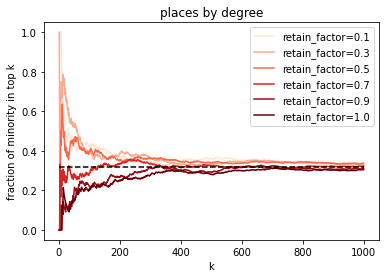

# brazil

### degree

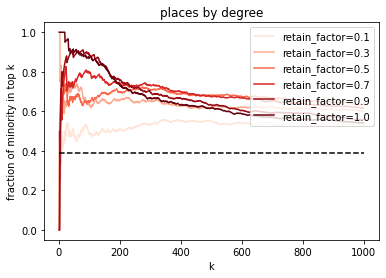

# dblp

### degree

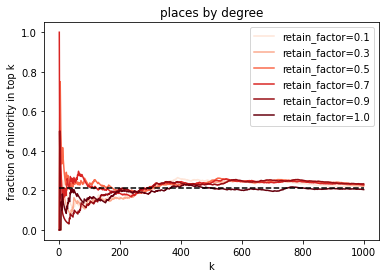

# github

### degree

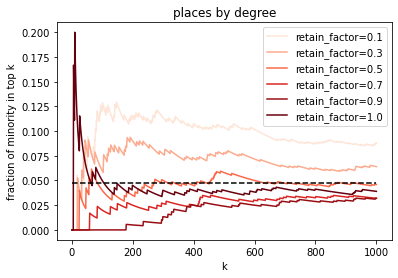

# pok

### degree

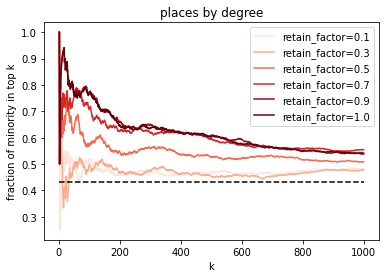

<Figure size 432x288 with 0 Axes>

In [106]:
display(Markdown("# similarity sampling"))
plot(result4, maxk=1000, show_std=False)#[np.logical_and(result4.retain_factor != 0.5, result4.retain_factor != 0.3 )])

In [57]:
def plot2(result, measure="degree", cmap=None, **kwargs):
    plt.set_cmap("Reds")
    for name in np.unique(result.name):
        display(Markdown(f"# {name}"))
        result_tmp = result[result.name ==name]
        for measure in ["degree"]:#, "pagerank", "katz"]:#, "katz", "betweenness"]:
            display(Markdown(f"### {measure}"))
            fig = plot_top_places(result_tmp, measure=measure,  groupby="alpha", cmap=cmap, **kwargs)
            display(fig)

In [58]:

    
def to_alpha(alpha, values):
    return values ** alpha

In [59]:
samp = AdditionalParamWrapper(SimilarityEdgeSampler(), partial(change_function_params, to_alpha), "alpha")
#samp.function
sampler_2 = ParametersZip(samp, {'sim_type':'jaccard', 'alpha' : [0, 0.01, 0.1, 0.5, 1.0, 2.0]})
result5 = GraphPipeline(graphs, measures, sampler=sampler_2).execute(repetitions=10)

edges 248450
edges 243614
edges 205127
edges 101372
edges 47024
edges 13075
edges 25109
edges 24316
edges 18926
edges 8493
edges 4184
edges 1134
edges 38540
edges 37409
edges 28816
edges 9916
edges 3057
edges 490
edges 3064
edges 3021
edges 2688
edges 1574
edges 851
edges 330
edges 619257
edges 613079
edges 561314
edges 398474
edges 282467
edges 173998
edges 248450
edges 243663
edges 205158
edges 101741
edges 47084
edges 13088
edges 25109
edges 24417
edges 19154
edges 8648
edges 4254
edges 1173
edges 38540
edges 37476
edges 28811
edges 10006
edges 3198
edges 497
edges 3064
edges 3026
edges 2662
edges 1619
edges 852
edges 332
edges 619257
edges 613151
edges 561874
edges 398549
edges 282450
edges 174381
edges 248450
edges 243690
edges 205214
edges 101814
edges 46992
edges 13276
edges 25109
edges 24393
edges 19068
edges 8645
edges 4115
edges 1137
edges 38540
edges 37442
edges 28968
edges 10072
edges 3150
edges 487
edges 3064
edges 3013
edges 2651
edges 1548
edges 855
edges 369
edges 61925

# aps

### degree

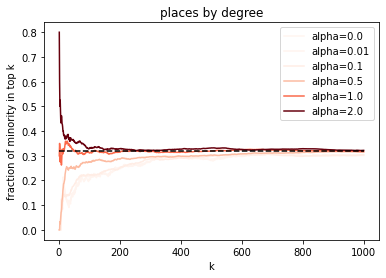

# brazil

### degree

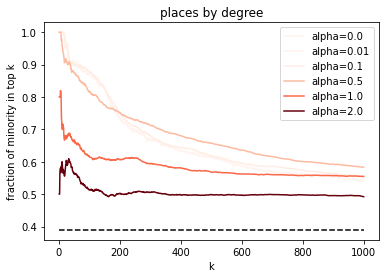

# dblp

### degree

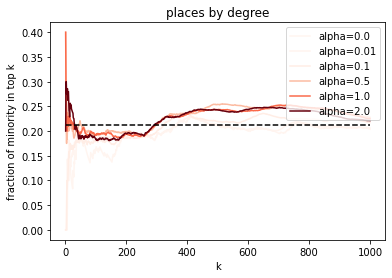

# github

### degree

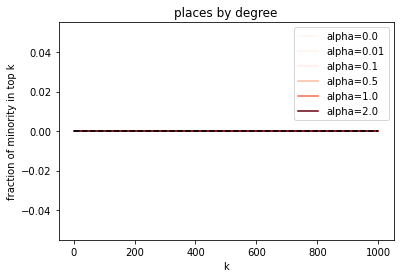

# pok

### degree

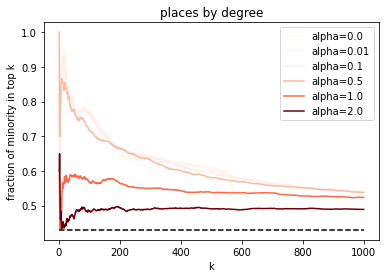

<Figure size 432x288 with 0 Axes>

In [60]:
plot2(result5, maxk=1000, show_std=False, cmap=my_cmap)

In [61]:
raise NotImplementedError

NotImplementedError: 

In [62]:
def plot3(result, measure="degree", cmap=None, **kwargs):
    plt.set_cmap("Reds")
    for name in np.unique(result.name):
        display(Markdown(f"# {name}"))
        result_tmp = result[result.name ==name]
        for measure in ["degree"]:#, "pagerank", "katz"]:#, "katz", "betweenness"]:
            display(Markdown(f"### {measure}"))
            fig = plot_distr(result_tmp, groupby="retain_factor", cmap=cmap, **kwargs)
            display(fig)


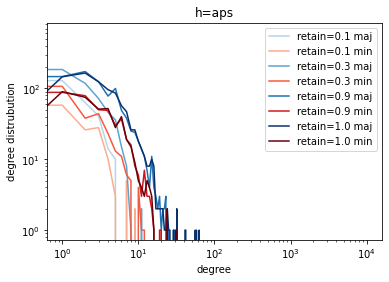

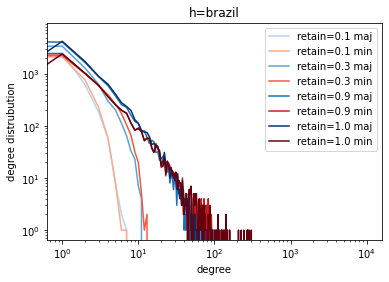

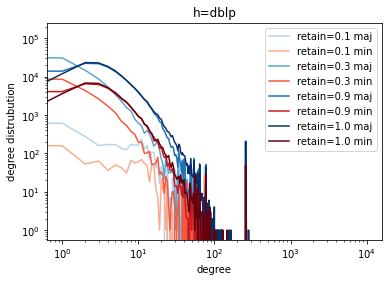

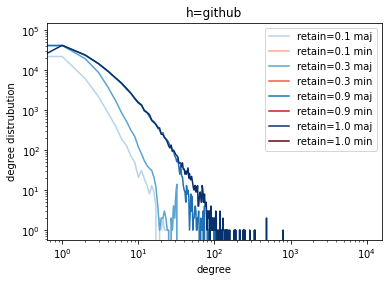

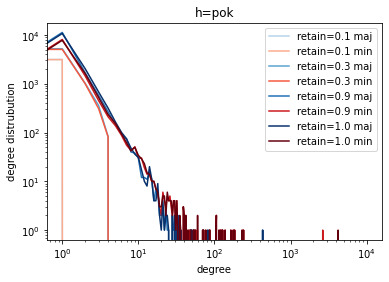

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [65]:
plot_distr_outer(result4, normalize=False, show_std=False)